# Exploring the NHANES diabetes data

[DSLC stages]: EDA


You can conduct an EDA of the NHANES diabetes dataset in this document.

In [5]:
import pandas as pd
import numpy as np

# Load the datasets from CSV files
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')
dictionary = pd.read_csv('dictionary.csv', index_col=0)

train_time_data = pd.read_csv('train_time_data.csv')
val_time_data = pd.read_csv('val_time_data.csv')
test_time_data = pd.read_csv('test_time_data.csv')
dict_time_series = pd.read_csv('dict_time_series.csv', index_col=0)

data_States = pd.read_csv('data_States.csv')
data_register = pd.read_csv('data_register.csv')
data_income = pd.read_csv('data_income.csv')
data_noVote = pd.read_csv('data_noVote.csv')

In [198]:
from scipy.stats import ttest_rel, t
import pandas as pd
import numpy as np

# Assuming train_data contains columns starting with "PRE_" and "POST_", and "weights"
pre_columns = [col for col in train_data.columns if col.startswith("PRE_")]
post_columns = [col for col in train_data.columns if col.startswith("POST_")]

# Match PRE and POST columns (ignoring "PRE_" and "POST_" prefixes)
pre_post_pairs = {
    pre: pre.replace("PRE_", "POST_") for pre in pre_columns if pre.replace("PRE_", "POST_") in post_columns
}

# Prepare a DataFrame to store test results
results = []

# Compare each PRE-POST pair
for pre_col, post_col in pre_post_pairs.items():
    pre_data = train_data[pre_col]
    post_data = train_data[post_col]
    weights = train_data['weights'].loc[pre_data.index]  # Align weights with data
    
    # Ensure equal length for paired testing
    paired_data = pd.DataFrame({
        "pre": pre_data,
        "post": post_data,
        "weights": weights
    }).dropna()
    
    pre_values = paired_data["pre"].astype(float)
    post_values = paired_data["post"].astype(float)
    weights = paired_data["weights"].astype(float)
    n = len(pre_values)  # Sample size
    
    # **Unweighted Tests**
    try:
        unweighted_t_stat, unweighted_p_value = ttest_rel(pre_values, post_values)
        unweighted_test_type = "t-test"
        
        # Calculate confidence intervals for unweighted test
        unweighted_mean_diff = post_values.mean() - pre_values.mean()
        unweighted_std_dev_diff = (post_values - pre_values).std()
        unweighted_se_diff = unweighted_std_dev_diff / np.sqrt(n)
        unweighted_t_critical = t.ppf(1 - 0.05 / 2, df=n - 1)
        unweighted_ci_lower = pre_values.mean() - unweighted_t_critical * unweighted_se_diff
        unweighted_ci_upper = pre_values.mean() + unweighted_t_critical * unweighted_se_diff
        
    except ValueError:
        # If t-test fails, default to Wilcoxon (non-parametric)
        unweighted_t_stat, unweighted_p_value = wilcoxon(pre_values, post_values)
        unweighted_test_type = "Wilcoxon"
        unweighted_ci_lower, unweighted_ci_upper = None, None  # CI not computed for Wilcoxon

    # **Weighted Tests**
    diff = post_values - pre_values
    weighted_mean_diff = np.sum(weights * diff) / np.sum(weights)
    weighted_var_diff = np.sum(weights * (diff - weighted_mean_diff) ** 2) / np.sum(weights)
    weighted_se_diff = np.sqrt(weighted_var_diff / n)  # Weighted standard error
    weighted_t_stat = weighted_mean_diff / weighted_se_diff
    df = n - 1  # Degrees of freedom
    pre_weighted_mean = (pre_values * weights).sum() / weights.sum(),
    post_weighted_mean = (post_values * weights).sum() / weights.sum()

    # Calculate p-value (two-tailed test)
    weighted_p_value = 2 * (1 - t.cdf(np.abs(weighted_t_stat), df))

    # Calculate confidence intervals for weighted test
    weighted_t_critical = t.ppf(1 - 0.05 / 2, df)
    weighted_ci_lower =  pre_weighted_mean - weighted_t_critical * weighted_se_diff
    weighted_ci_upper =  pre_weighted_mean + weighted_t_critical * weighted_se_diff

    # Store results
    results.append({
        "Variable": pre_col.replace("PRE_", ""),
        "PRE_Mean_Unweighted": pre_values.mean(),
        "POST_Mean_Unweighted": post_values.mean(),
        "PRE_Mean_Weighted":  pre_weighted_mean,
        "POST_Mean_Weighted":  post_weighted_mean,
        "Unweighted_Test_Type": unweighted_test_type,
        "Unweighted_Mean_Difference": unweighted_mean_diff,
        "Unweighted_CI_Lower": unweighted_ci_lower,
        "Unweighted_CI_Upper": unweighted_ci_upper,
        "Unweighted_T_Statistic": unweighted_t_stat,
        "Unweighted_P_Value": unweighted_p_value,
        "Weighted_Mean_Difference": weighted_mean_diff,
        "Weighted_CI_Lower": weighted_ci_lower,
        "Weighted_CI_Upper": weighted_ci_upper,
        "Weighted_T_Statistic": weighted_t_stat,
        "Weighted_P_Value": weighted_p_value
    })

# Convert results to a DataFrame
comparison_results = pd.DataFrame(results)

# Display significant changes (p-value < 0.05 for weighted and unweighted)
significant_unweighted = comparison_results[comparison_results["Unweighted_P_Value"] < 0.05]
significant_weighted = comparison_results[comparison_results["Weighted_P_Value"] < 0.05]

print("All variables considered\n", comparison_results["Variable"])
print()

print("Significant Changes from Pre to Post (Unweighted):")
print(significant_unweighted[['Variable','PRE_Mean_Unweighted','POST_Mean_Unweighted','Unweighted_P_Value']])

print("\nSignificant Changes from Pre to Post (Weighted):")
print(significant_weighted[['Variable','PRE_Mean_Weighted','POST_Mean_Weighted','Weighted_P_Value']])


All variables considered
 0                    ThermoBiden
1                    ThermoTrump
2                   ThermoHarris
3                    ThermoPence
4                   VoteAccuracy
5     VotePresident_Donald Trump
6     VotePresident_Jo Jorgensen
7    VotePresident_Howie Hawkins
Name: Variable, dtype: object

Significant Changes from Pre to Post (Unweighted):
                      Variable  PRE_Mean_Unweighted  POST_Mean_Unweighted  \
0                  ThermoBiden            49.048482             51.159248   
1                  ThermoTrump            40.678054             39.785197   
2                 ThermoHarris            47.819186             49.453416   
3                  ThermoPence            44.384231             47.273292   
4                 VoteAccuracy             3.074534              2.289683   
5   VotePresident_Donald Trump             0.449275              0.493444   
6   VotePresident_Jo Jorgensen             0.030538              0.010870   
7  VotePresi

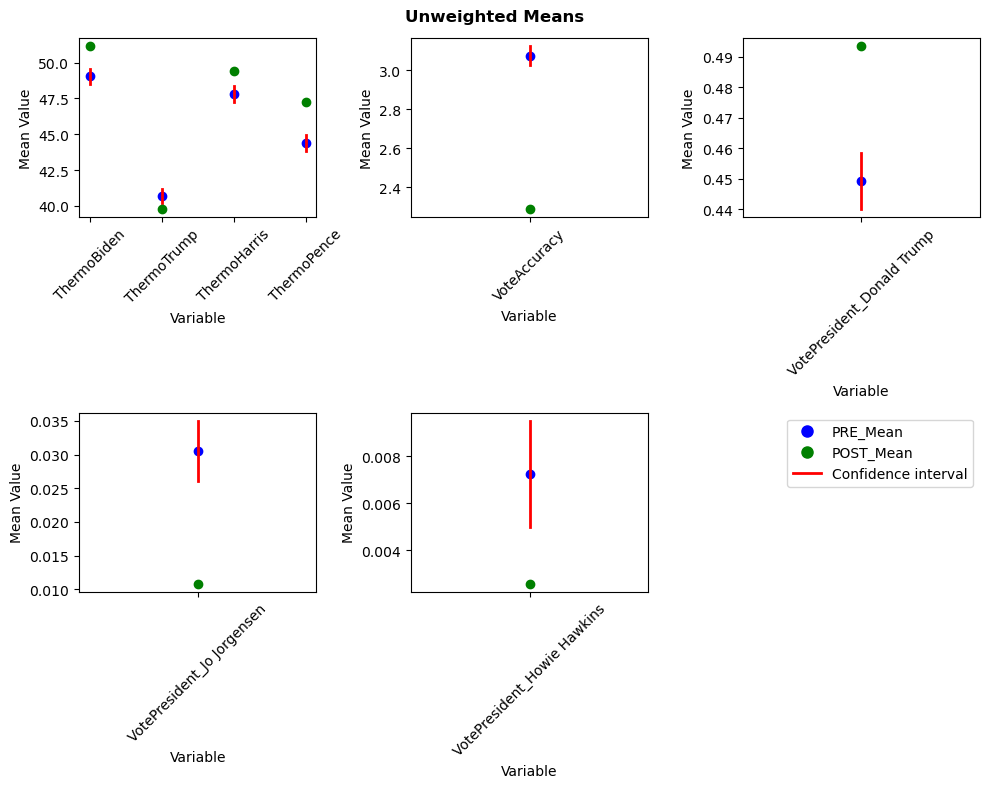

In [199]:
import matplotlib.pyplot as plt

unweighted_data = weighted_data = comparison_results

# Create a figure and axes for subplots (2x2 grid)
fig, axes = plt.subplots(2, 3, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

# Loop for first 4 variables (subplot 1)
for i, var in enumerate(unweighted_data["Variable"][:4]):
    ax = axes[0]  # Use the first subplot (top-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i], unweighted_data["Unweighted_CI_Upper"][i]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Subplot 2 (for variable index 4)
ax = axes[1]  # Use the second subplot (top-right)
var = unweighted_data["Variable"][4]

# Plot the points for PRE_Mean
ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][4], 'o', color='blue', label='PRE_Mean')

# Add confidence interval lines
ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][4], unweighted_data["Unweighted_CI_Upper"][4]], 
        color='red', label='Confidence interval', lw=2)

# Plot the points for POST_Mean
ax.plot(var, unweighted_data["POST_Mean_Unweighted"][4], 'o', color='green', label='POST_Mean')


# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][5:6]):
    ax = axes[2]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i+5], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i+5], unweighted_data["Unweighted_CI_Upper"][i+5]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i+5], 'o', color='green', label='POST_Mean' if i == 0 else "")
    
# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][6:7]):
    ax = axes[3]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i+6], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i+6], unweighted_data["Unweighted_CI_Upper"][i+6]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i+6], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][7:]):
    ax = axes[4]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i+7], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i+7], unweighted_data["Unweighted_CI_Upper"][i+7]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i+7], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Remove the 4th subplot (bottom-right) by turning off its axis
axes[5].axis('off')


import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create custom legend handles
blue_dot = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='PRE_Mean')
green_dot = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=8, label='POST_Mean')
red_line = mlines.Line2D([], [], color='red', linestyle='-', linewidth=2, label='Confidence interval')

# Add the custom legend
plt.legend(handles=[blue_dot, green_dot, red_line], loc='best', fontsize=10)

# Adjust the x-axis labels for all subplots (tilt them)
for ax in axes:
    ax.set_xlabel('Variable')
    ax.set_ylabel('Mean Value')
    ax.tick_params(axis='x', rotation=45)  # Tilt the x-axis labels

# Add the legend in the bottom-right of the figure
#fig.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=12)

# Adjust layout to avoid overlap
fig.suptitle('Unweighted Means', fontweight='bold')
plt.tight_layout()
plt.show()


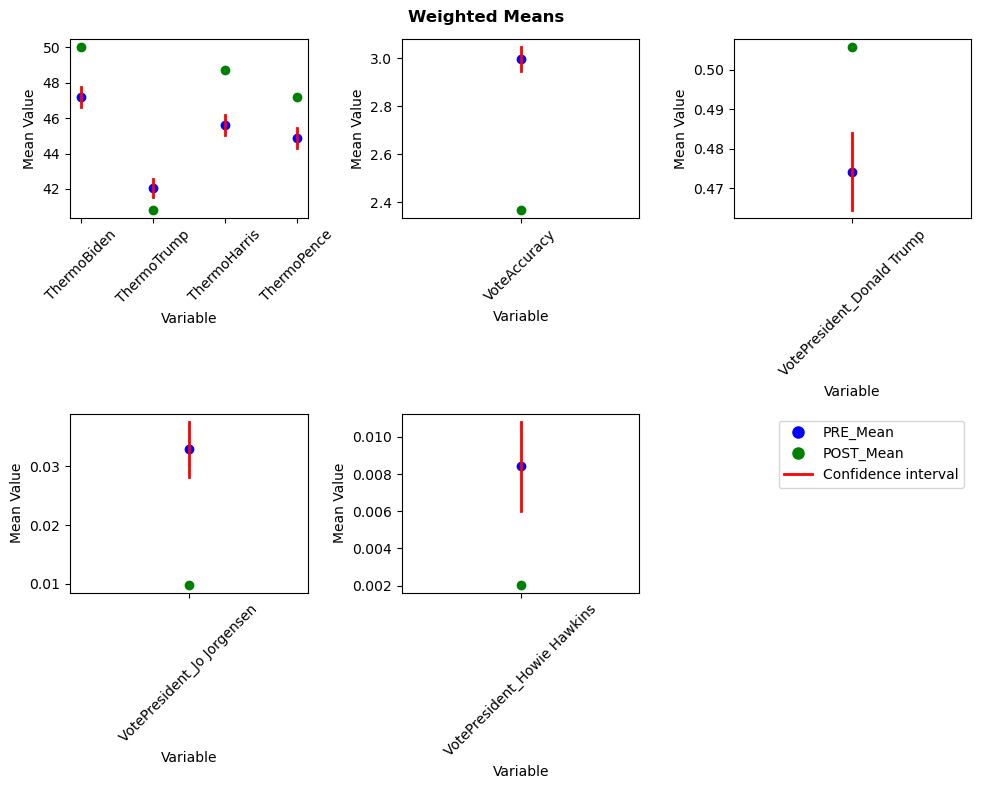

In [200]:
import matplotlib.pyplot as plt

unweighted_data = weighted_data = comparison_results

# Create a figure and axes for subplots (2x2 grid)
fig, axes = plt.subplots(2, 3, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

# Loop for first 4 variables (subplot 1)
for i, var in enumerate(weighted_data["Variable"][:4]):
    ax = axes[0]  # Use the first subplot (top-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i], weighted_data["Weighted_CI_Upper"][i]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Subplot 2 (for variable index 4)
ax = axes[1]  # Use the second subplot (top-right)
var = weighted_data["Variable"][4]

# Plot the points for PRE_Mean
ax.plot(var, weighted_data["PRE_Mean_Weighted"][4], 'o', color='blue', label='PRE_Mean')

# Add confidence interval lines
ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][4], weighted_data["Weighted_CI_Upper"][4]], 
        color='red', label='Confidence interval', lw=2)

# Plot the points for POST_Mean
ax.plot(var, weighted_data["POST_Mean_Weighted"][4], 'o', color='green', label='POST_Mean')

# Loop for remaining variables (subplot 3)
for i, var in enumerate(weighted_data["Variable"][5:6]):
    ax = axes[2]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i+5], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i+5], weighted_data["Weighted_CI_Upper"][i+5]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i+5], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Loop for remaining variables (subplot 3)
for i, var in enumerate(weighted_data["Variable"][6:7]):
    ax = axes[3]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i+6], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i+6], weighted_data["Weighted_CI_Upper"][i+6]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i+6], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Loop for remaining variables (subplot 3)
for i, var in enumerate(weighted_data["Variable"][7:]):
    ax = axes[4]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i+7], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i+7], weighted_data["Weighted_CI_Upper"][i+7]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i+7], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Remove the 4th subplot (bottom-right) by turning off its axis
axes[5].axis('off')


import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create custom legend handles
blue_dot = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='PRE_Mean')
green_dot = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=8, label='POST_Mean')
red_line = mlines.Line2D([], [], color='red', linestyle='-', linewidth=2, label='Confidence interval')

# Add the custom legend
plt.legend(handles=[blue_dot, green_dot, red_line], loc='best', fontsize=10)


# Adjust the x-axis labels for all subplots (tilt them)
for ax in axes:
    ax.set_xlabel('Variable')
    ax.set_ylabel('Mean Value')
    ax.tick_params(axis='x', rotation=45)  # Tilt the x-axis labels

# Add the legend in the bottom-right of the figure
#fig.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=12)

# Adjust layout to avoid overlap
fig.suptitle('Weighted Means', fontweight='bold')
plt.tight_layout()
plt.show()

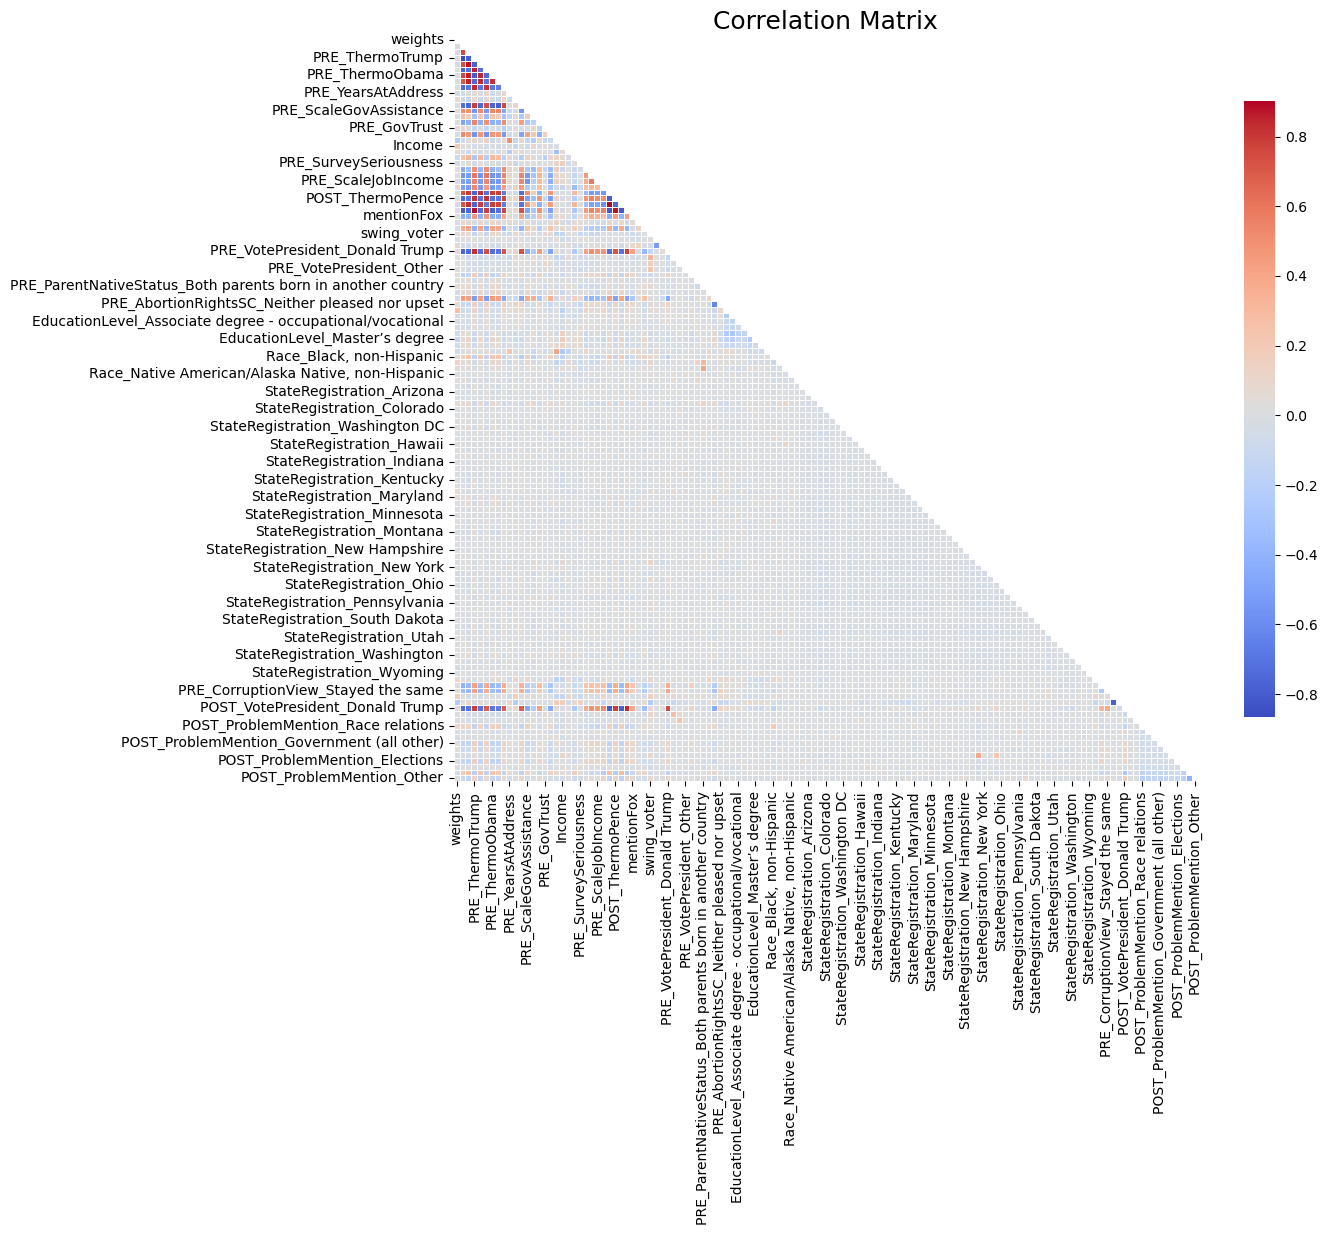

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix =  train_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap with customizations
sns.heatmap(correlation_matrix, 
            annot=False,                # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask = mask,
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,           # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 6})   # Adjust the font size for annotations

# Add title
plt.title('Correlation Matrix', fontsize=18)
plt.savefig('Correlation Matrix Heat Map')
plt.show()

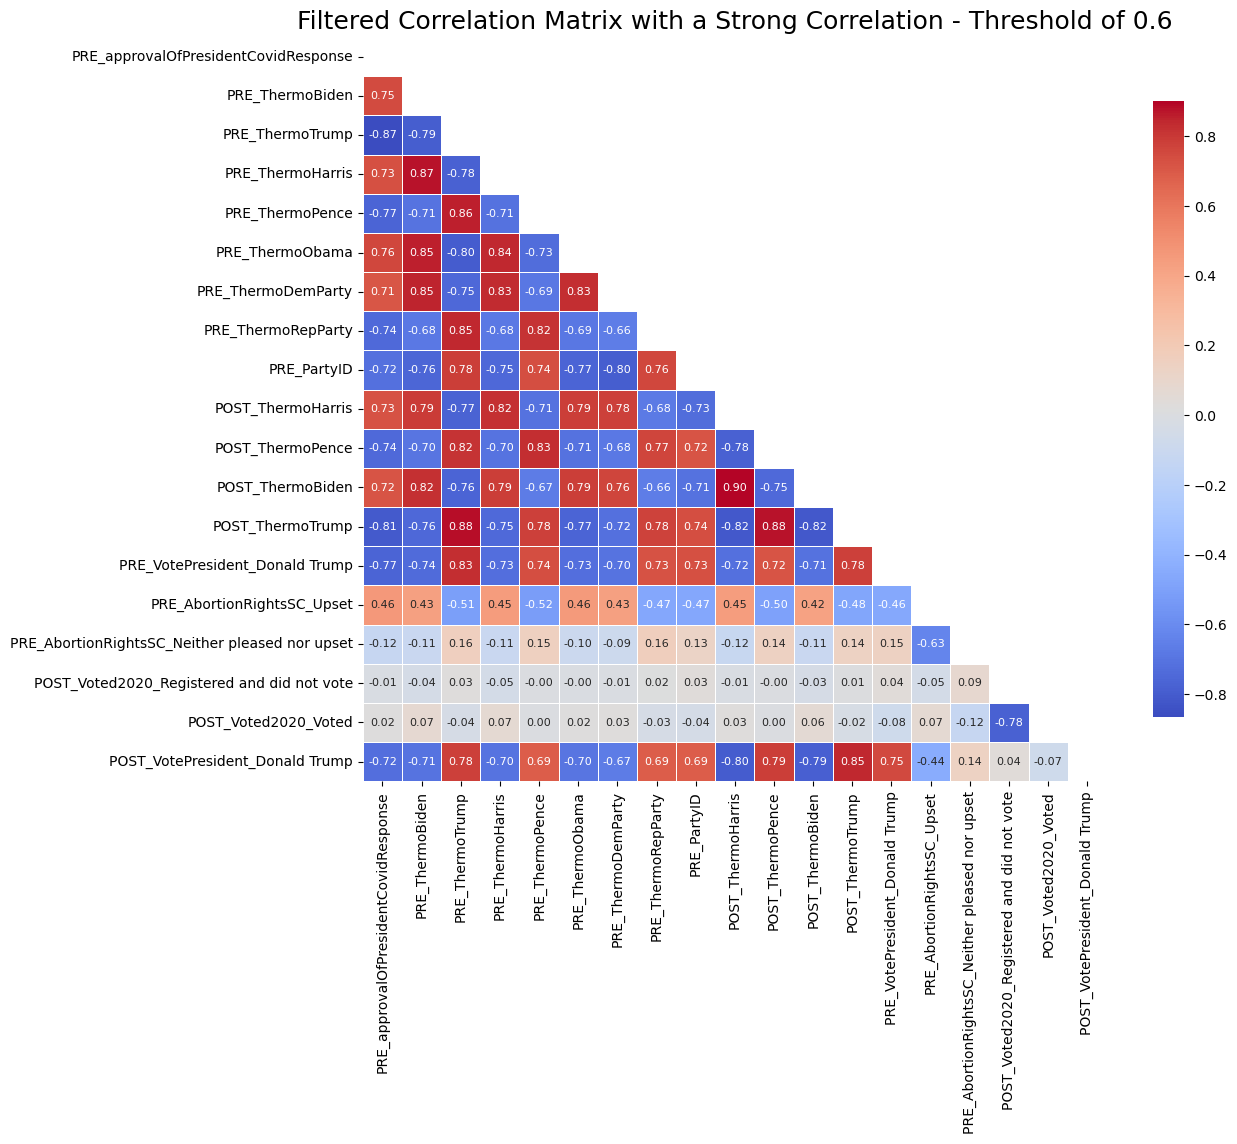

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a threshold for strong correlations
threshold = 0.6

# Filter the correlation matrix
filtered_correlation_matrix = correlation_matrix.copy()
filtered_correlation_matrix[
    (filtered_correlation_matrix < threshold) & (filtered_correlation_matrix > -threshold)
] = np.nan  # Replace weak correlations with NaN
# Set diagonal elements to NaN
np.fill_diagonal(filtered_correlation_matrix.values, np.nan)

# Drop rows and columns that are completely NaN
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=0, how='all')  # Drop rows
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=1, how='all')  # Drop columns

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(filtered_correlation_matrix, dtype=bool))

# Identify columns and rows that are not NaN in the filtered correlation matrix
valid_columns = filtered_correlation_matrix.dropna(axis=1, how='all').columns
valid_rows = filtered_correlation_matrix.dropna(axis=0, how='all').index

# Create a new plot matrix that only includes the valid rows and columns
plot_matrix = correlation_matrix.loc[valid_rows, valid_columns]
#print(plot_matrix)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with customizations
sns.heatmap(plot_matrix, 
            annot=True,               # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask=mask,                # Mask the upper triangle
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,            # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 8})    # Adjust the font size for annotations

# Add title
plt.title('2020 Filtered Correlation Matrix with a Strong Correlation - Threshold of '+str(threshold), fontsize=18)

# Save the plot
plt.savefig('Filtered_Correlation_Matrix.png', dpi=300)

# Show the plot
plt.show()

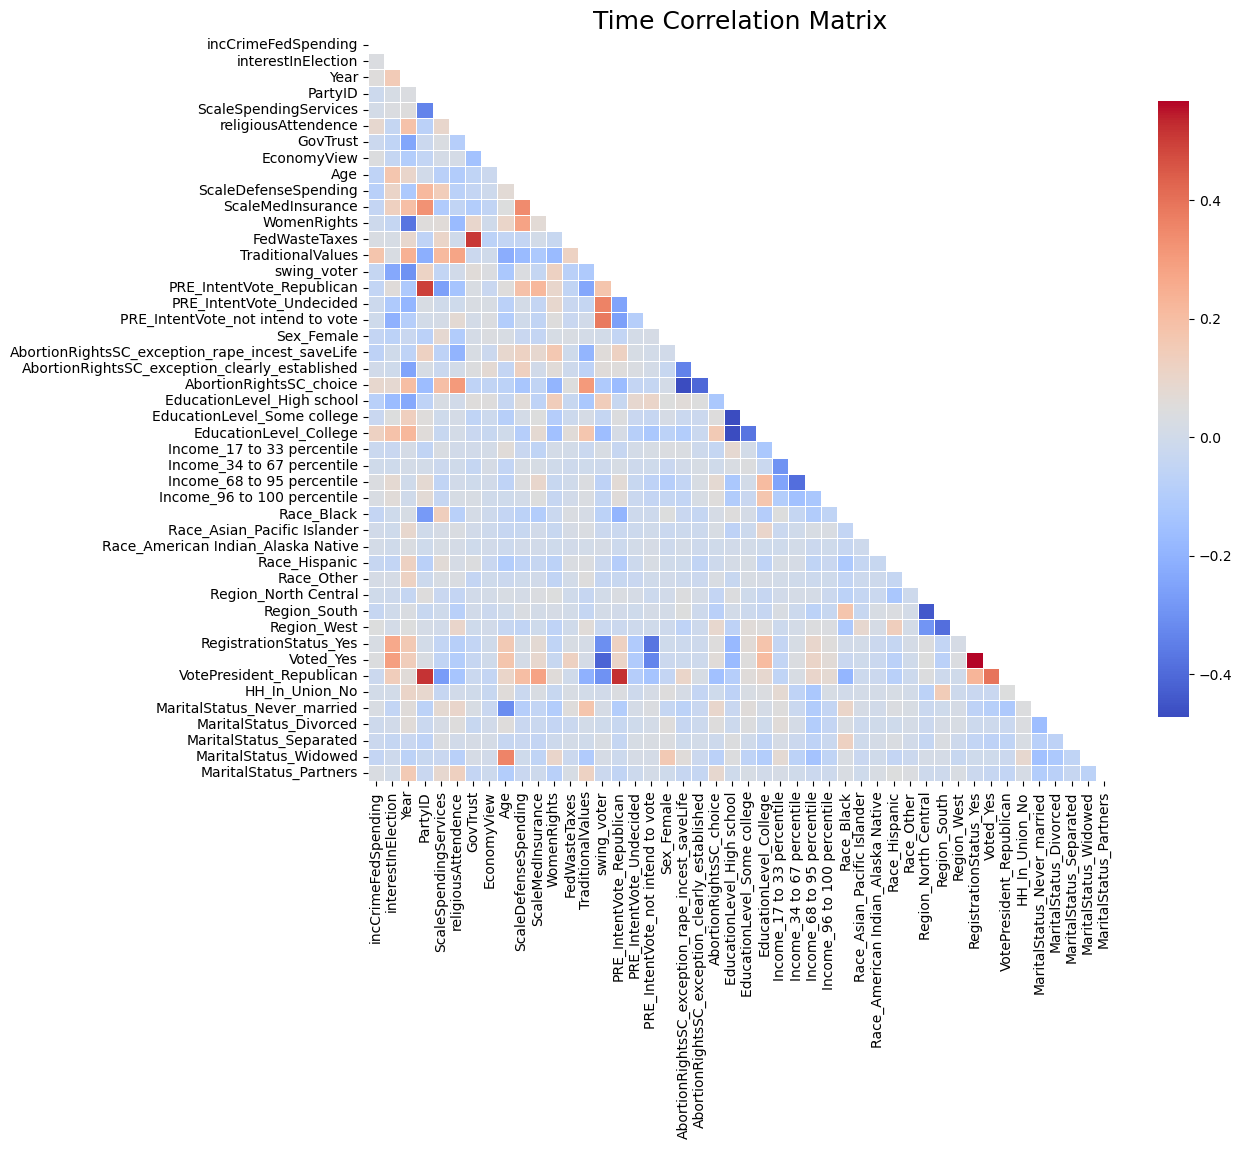

In [246]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix_time =  train_time_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_time, dtype=bool))

# Create a heatmap with customizations
sns.heatmap(correlation_matrix_time, 
            annot=False,                # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask = mask,
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,           # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 6})   # Adjust the font size for annotations

# Add title
plt.title('Time Correlation Matrix', fontsize=18)
plt.savefig('Time Correlation Matrix Heat Map')
plt.show()

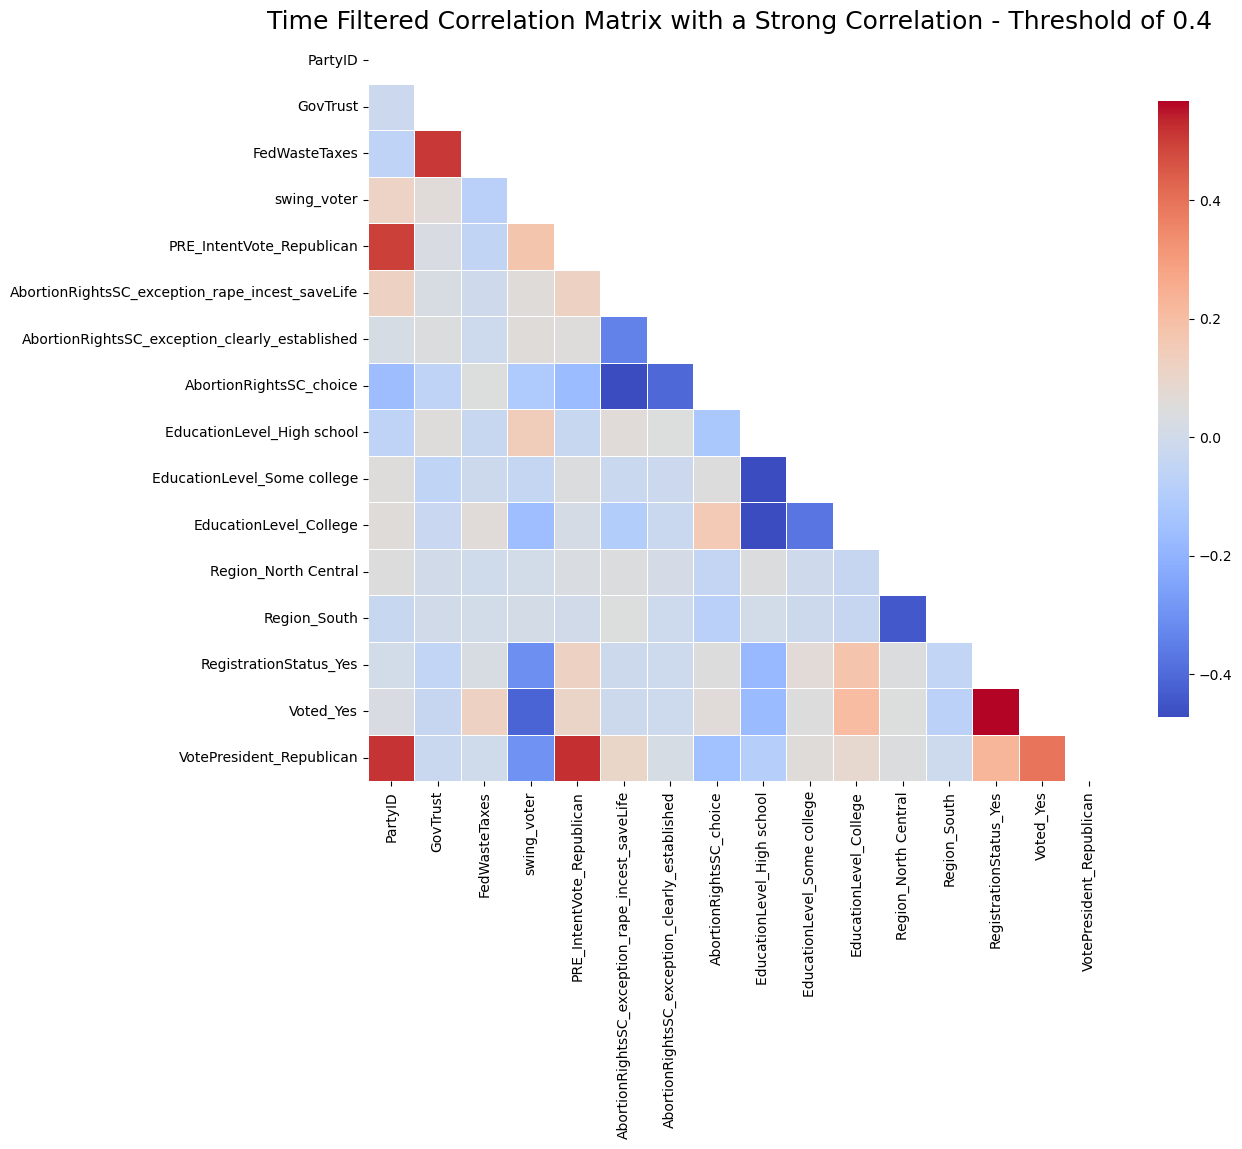

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a threshold for strong correlations
threshold = 0.4

# Filter the correlation matrix
filtered_correlation_matrix = correlation_matrix_time.copy()
filtered_correlation_matrix[
    (filtered_correlation_matrix < threshold) & (filtered_correlation_matrix > -threshold)
] = np.nan  # Replace weak correlations with NaN
# Set diagonal elements to NaN
np.fill_diagonal(filtered_correlation_matrix.values, np.nan)

# Drop rows and columns that are completely NaN
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=0, how='all')  # Drop rows
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=1, how='all')  # Drop columns

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(filtered_correlation_matrix, dtype=bool))

# Identify columns and rows that are not NaN in the filtered correlation matrix
valid_columns = filtered_correlation_matrix.dropna(axis=1, how='all').columns
valid_rows = filtered_correlation_matrix.dropna(axis=0, how='all').index

# Create a new plot matrix that only includes the valid rows and columns
plot_matrix = correlation_matrix.loc[valid_rows, valid_columns]
#print(plot_matrix)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with customizations
sns.heatmap(plot_matrix, 
            annot=False,               # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask=mask,                # Mask the upper triangle
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,            # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 8})    # Adjust the font size for annotations

# Add title
plt.title('Time Filtered Correlation Matrix with a Strong Correlation - Threshold of '+str(threshold), fontsize=18)

# Save the plot
plt.savefig('Filtered_Correlation_Matrix.png', dpi=300)

# Show the plot
plt.show()

In [253]:
swing_stats = train_data.groupby('swing_voter').mean()
print(swing_stats)


             weights  PRE_approvalOfPresidentCovidResponse  PRE_ThermoBiden  \
swing_voter                                                                   
False        0.96626                              2.844552        48.383263   
True         1.08682                              3.349823        52.924617   

             PRE_ThermoTrump  PRE_ThermoHarris  PRE_ThermoPence  \
swing_voter                                                       
False              42.939155         47.334142        46.147160   
True               27.502945         50.645465        34.111896   

             PRE_ThermoObama  PRE_ThermoDemParty  PRE_ThermoRepParty  \
swing_voter                                                            
False              58.647463           44.270669           45.495654   
True               70.921084           50.857479           35.955241   

             PRE_YearsAtAddress  ...  POST_ProblemMention_Race relations  \
swing_voter                      ...             

In [257]:
import scipy.stats as stats

# Separate the data into two groups
group_0 = train_data[train_data['swing_voter'] == 0]
group_1 = train_data[train_data['swing_voter'] == 1]

# Perform a two-sample t-test for each numeric column
results = {}
for column in train_data.select_dtypes(include='number').columns:
    if column != 'swing_voter':  # Exclude the grouping column
        t_stat, p_value = stats.ttest_ind(group_0[column], group_1[column], nan_policy='omit')
        results[column] = {
            't_statistic': t_stat,
            'p_value': p_value,
            'mean_group_0': group_0[column].mean(),
            'mean_group_1': group_1[column].mean(),
            'significant': p_value <= 0.05  # True if significant at alpha=0.05
        }

# Display the results
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)

                                     t_statistic   p_value mean_group_0  \
weights                                -3.326726  0.000884      0.96626   
PRE_approvalOfPresidentCovidResponse  -10.542243       0.0     2.844552   
PRE_ThermoBiden                        -3.561351  0.000372    48.383263   
PRE_ThermoTrump                        10.430917       0.0    42.939155   
PRE_ThermoHarris                       -2.562613  0.010414    47.334142   
PRE_ThermoPence                         9.071253       0.0     46.14716   
PRE_ThermoObama                        -8.992233       0.0    58.647463   
PRE_ThermoDemParty                     -5.509707       0.0    44.270669   
PRE_ThermoRepParty                      7.931824       0.0    45.495654   
PRE_YearsAtAddress                      8.266885       0.0    12.644835   
PRE_SummaryVoteDutyChoice              -7.481316       0.0     3.160501   
PRE_PartyID                             6.329912       0.0     3.976551   
PRE_ScaleGovAssistance   

In [254]:
swing_stats = train_time_data.groupby('swing_voter').mean()
print(swing_stats)

             incCrimeFedSpending  interestInElection         Year   PartyID  \
swing_voter                                                                   
False                   1.465794            2.249008  2002.033148  3.475536   
True                    1.418357            1.863126  1992.079448  3.964527   

             ScaleSpendingServices  religiousAttendence   GovTrust  \
swing_voter                                                          
False                     3.973684             3.218637  26.410341   
True                      3.811694             3.218622  29.467141   

             EconomyView        Age  ScaleDefenseSpending  ...  Region_West  \
swing_voter                                                ...                
False           3.459931  48.504099              4.024729  ...     0.212818   
True            3.554603  43.952331              4.157572  ...     0.194508   

             RegistrationStatus_Yes  Voted_Yes  VotePresident_Republican  \
swing_vot

In [256]:
import scipy.stats as stats

# Separate the data into two groups
group_0 = train_time_data[train_time_data['swing_voter'] == 0]
group_1 = train_time_data[train_time_data['swing_voter'] == 1]

# Perform a two-sample t-test for each numeric column
results = {}
for column in train_time_data.select_dtypes(include='number').columns:
    if column != 'swing_voter':  # Exclude the grouping column
        t_stat, p_value = stats.ttest_ind(group_0[column], group_1[column], nan_policy='omit')
        results[column] = {
            't_statistic': t_stat,
            'p_value': p_value,
            'mean_group_0': group_0[column].mean(),
            'mean_group_1': group_1[column].mean(),
            'significant': p_value <= 0.05  # True if significant at alpha=0.05
        }

# Display the results
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)


                      t_statistic   p_value mean_group_0 mean_group_1  \
incCrimeFedSpending      7.661519       0.0     1.465794     1.418357   
interestInElection      46.726203       0.0     2.249008     1.863126   
Year                    60.904262       0.0  2002.033148  1992.079448   
PartyID                -21.885389       0.0     3.475536     3.964527   
ScaleSpendingServices    9.094663       0.0     3.973684     3.811694   
religiousAttendence      0.000932  0.999256     3.218637     3.218622   
GovTrust               -11.889195       0.0    26.410341    29.467141   
EconomyView             -7.464791       0.0     3.459931     3.554603   
Age                     23.470083       0.0    48.504099    43.952331   
ScaleDefenseSpending    -7.553379       0.0     4.024729     4.157572   
ScaleMedInsurance        7.573595       0.0     3.295028     3.123841   
WomenRights            -23.680128       0.0     1.893282     2.313193   
FedWasteTaxes           14.731088       0.0     1.3

In [203]:
import importlib
# Import the function
from functions import explore_data_helper

# Reload the module to reflect any updates
importlib.reload(explore_data_helper)

# create a list of 100 perturbed versions of ames_train_preprocessed using the perturb_ames function
perturbed_data = [explore_data_helper.perturb_dataframe(train_data) for i in range(100)]

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.4152612  3.96540558 4.05416435 ... 3.89518212 0.72586343 4.02119085]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[98.82511201 54.82792504 13.26539568 ... 83.14947017 35.83519231
 40.37862105]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.46802388 4.2369135  3.96681314 ... 3.28674496 1.14327622 1.54318868]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[57.49948181 37.48681906 22.46008866 ... 28.23285585 -9.30143784
 85.84167027]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.18894232 -0.0664628  -0.1088887  ...  0.22077929  0.05780134
  0.83231294]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.13849603 0.06852458 0.97463981 ... 0.0281682  1.0721165  1.00223404]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 55.30745466 -18.42655127  -8.02780255 ...   8.49887    -11.45891007
  -8.09274842]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.01881872 -0.1519872  -0.16314692 ...  0.17923367  0.0865394
 -0.06139065]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documen

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.90827205 2.56297002 0.90856385 ... 4.76655521 3.488297   3.68441768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.73699719 4.73890102 5.10294106 ... 4.69417018 4.85428724 5.25335779]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.18080743 4.20910577 4.54987023 ... 4.18710396 3.31042253 4.8246275 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.88000133 6.78154661 7.35438612 ... 3.77249777 3.71541014 3.90940652]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.02630953 -0.1828672   0.25238433 ... -0.47700787 -0.1583359
  2.83344059]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.06208531 2.38515309 4.54460307 ... 1.95508007 2.94040743 4.66276588]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functi

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.21679317 5.02569822 4.86856729 ... 5.30866475 4.83027    5.10901849]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.29779275 2.42113246 3.02383966 ... 1.26014878 4.68764172 4.77010073]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.17861046 1.39530047 1.10402633 ... 4.50694943 0.61216254 2.3235371 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 77.54882711  82.31771797  60.14467951 ...   1.08549489  68.68988065
 117.56421309]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.62479798 3.94450585 6.51810789 ... 1.10871081 1.91071725 7.50498509]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.27318957 2.47529828 6.13262863 ... 3.88185064 5.11549598 3.10860931]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.95733693 4.6732105  2.9064135  ... 5.18916093 3.20611167 0.82959534]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.15690447 5.25228223 4.83342437 ... 4.76716632 5.22572397 4.76092941]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.64919334 2.7219035  3.82321156 ... 1.62961341 3.34919709 3.55748629]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -1.08428566  71.19788472  56.13634692 ... -16.43407826  87.53780956
  -6.03068154]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.94952195 6.68818174 2.49002526 ... 7.05945884 2.75336373 7.77642191]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.93528266 0.66994839 4.60891926 ... 1.6275789  2.53806539 3.5967573 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.07911153 6.58282527 5.69632119 ... 5.45419731 4.60198716 6.35073198]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.67523408 1.41364883 7.17601771 ... 8.01385774 5.29750076 3.86674689]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.28715441  8.67337692  4.43138879 ...  3.29579102 23.80714628
 24.58653575]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.08822647 -0.30402702  0.18640673 ... -0.32988426 -0.28921571
 -0.42799767]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentatio

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.07715563 3.39092659 2.48810651 ... 4.37833598 4.43569836 1.6008427 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[105.93725848  15.75629379  97.90486652 ...  15.87237986 100.65150496
 116.03883687]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[109.35592396  50.92099565  56.57959409 ...  91.17244341  13.96970048
  85.92449836]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[115.5138239   22.67165394  -9.30358364 ...  65.5009275  104.26055384
  -0.92076157]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.43830151 -0.44862366 -0.25721278 ...  0.1626292  -0.51233411
  2.02429638]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.40464459 4.36941678 4.46090987 ... 4.28806484 2.6390864  4.04480032]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.47463124 0.44891348 2.48097745 ... 0.26711766 1.09554724 0.01945052]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.77986613 3.06286061 4.18553611 ... 4.01840661 4.38593151 1.16421719]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.34522075e-01  5.78208915e-02 -3.70746544e-01 ...  3.47083223e+00
  1.43788114e-03  4.65123451e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.72961171 2.48641834 3.06300013 ... 4.06538035 1.48248488 4.51254338]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.26344882 1.47440543 3.9793686  ... 3.59925237 4.4833977  1.62217694]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.93500175 13.87971916  9.95785307 ...  7.53678947  0.15235973
  5.8374677 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.04595238 3.28968639 0.88675449 ... 6.76259161 4.1346032  3.72920537]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.54307729 0.91811983 2.30512596 ... 3.58044646 4.36626724 1.73226481]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  9.24289359  -5.39618374  96.99243484 ...   6.42434771 -12.6817225
  66.89513724]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.12356593  0.03408928 -0.06984032 ...  0.78482644  0.12713257
 -0.02171872]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documen

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.41038301  3.22958865  2.92022253 ...  0.98529989  0.00505707
 -0.11294167]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.03089322 4.19228768 0.89787168 ... 1.38809515 4.41810429 2.76127277]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.63202523 2.47890923 2.16212484 ... 1.80407337 4.30974274 2.01427533]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.34466491 2.41823202 0.99863448 ... 1.18372371 2.9731081  2.00404439]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.60400001 3.82930704 4.63251031 ... 4.56053287 3.87953405 3.7236723 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[91.85868624 29.38696247 24.12873146 ... 70.34461889 55.29958088
 -4.33585408]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.13892984 -0.20094708 -0.13268579 ...  0.90026604  1.04321107
 -0.03651303]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.49937315 3.86674253 1.98316472 ... 3.56786303 2.16954115 2.22380291]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.91124292 3.79113433 2.37537167 ... 4.58320116 4.16689345 2.80147068]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[71.71810685 -2.0451667  45.39735151 ... 32.86722835 54.02086901
 -5.33288828]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.48161159 4.14584857 0.60179316 ... 4.50569134 1.77367465 3.8220784 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[11.49613859 90.79584744 61.96734383 ... 41.92141621 34.27356843
 79.6054785 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.71291749 3.57342754 4.33629517 ... 3.70673165 1.64262336 3.48734679]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[73.19865346 80.96625929 56.66510757 ... 47.93934881 60.17994988
 84.01512172]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.60095441 0.54607807 1.40184066 ... 4.08945086 1.11944799 2.65107762]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[49.15641799 94.7513236  34.94002592 ... 75.06122741 -4.09436395
 65.79506161]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.6250717  1.21038653 0.63776065 ... 2.40444366 4.35894185 1.09812581]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[10.85080322 70.93954422 75.17960866 ... 70.12544692 11.25270004
 82.54288499]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.94753315 1.89195033 0.34894675 ... 5.53808307 1.99152116 1.2567851 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.20127943 3.292257   5.1621847  ... 6.36260251 2.13418868 4.16758887]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.09441877  0.00412561  0.98530635 ...  0.81026996 -0.08043932
  0.86930307]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.70783401 0.74520524 3.87953638 ... 2.26852202 3.63026511 1.10686816]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.61177602 4.30490707 4.03874012 ... 4.37805179 4.2062309  1.13455491]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[48.19882066 28.8186376  84.59431557 ... 33.48800376 75.74881946
 48.11310366]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.81646513 2.35037133 3.7730792  ... 2.03817267 3.6583274  0.74377868]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 7.75630678e-02  9.70790825e+01  8.73624361e+01 ...  1.10034144e+02
 -1.21232725e+01  9.67097986e+01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 13.8574232  -16.35442981  90.35224831 ...  41.86223844  63.09091177
  58.11147457]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.7542659  42.53614442 19.78500079 ... 79.59590659 38.20669497
 30.8700803 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_docume

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -3.65570999  73.54259605 -11.73427108 ... -16.0992757   26.70291678
  95.84521096]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 27.12623897 107.5252838  -16.80886538 ...  44.5633545   86.24587996
 116.17942375]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 8.92569944  4.79278908 14.02691247 ...  4.67123042 -0.81465808
  5.93661515]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.47836435 -0.28892463  0.03164651 ... -0.25704235 -0.26252667
  0.28869932]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentatio

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.43963781 2.80293702 4.15792885 ... 3.13850414 0.47151608 1.33241564]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.89330526 4.76378921 5.01684196 ... 5.03879762 4.74359137 5.28695772]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[15.44144098 -0.06925006 11.6207253  ...  4.49922374  9.1079077
  3.57593557]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.54928287  2.6896851  -0.43294738 ... -0.02784817  0.48777654
 -0.2185107 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.70454766 5.8512887  5.13994943 ... 2.09884829 3.55634612 7.38158362]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.0598309  5.7606992  5.38098867 ... 5.25066555 5.92001228 4.6967606 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.18075245  0.89883319 -0.04004428 ...  0.03129697 -0.22608147
  0.05663437]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.82638241 3.59881841 1.2986038  ... 1.69326007 3.61624612 2.50043733]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.85026258 1.51826191 3.36056071 ... 4.23623624 3.80939979 0.89160923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 60.85397121  -8.13125883 106.24909929 ... 110.93660606  57.05700505
  39.59512148]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.91241874 3.58079047 4.61283006 ... 1.24269377 2.10610557 0.71598019]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[67.29590913 92.67228592 35.07321476 ... 38.82749415 37.20124833
 93.83830667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.233783   4.28225871 4.3875997  ... 1.52814039 0.7753609  4.44021713]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  6.21134666 105.68110664 100.97253213 ...  77.41809038  19.62525118
  34.96160938]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.76240313 3.3366574  3.67477364 ... 0.49213921 4.64088958 4.65041701]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 59.24414284  84.55611715 100.89935417 ...  53.84205341  43.86075332
  65.89319631]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 56.03125003  20.99168475 -14.65430595 ...  -3.19766597  15.56342405
  10.18856229]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.15735152 -0.17264159  0.07276273 ... -0.1110449  -0.11147253
  0.17764348]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_docume

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.22408122 4.50471916 2.89710791 ... 2.58361358 4.4555985  2.67612917]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.2734662  4.18887027 4.84378994 ... 5.26497193 4.77540542 3.97476161]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.52539299 2.72485302 1.69218789 ... 1.2201562  1.37319085 4.03753579]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.78664197 4.20961709 3.77530685 ... 4.06349742 3.99358915 3.97875796]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.90856719 1.70859766 0.88707399 ... 3.34262493 5.43336915 4.3397604 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.48321159 3.24812722 4.38518631 ... 5.41368254 1.23645695 2.34488962]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.36680319 5.19453652 4.19186812 ... 6.65022403 3.46892761 3.75950478]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.47742817 1.78337027 6.17915862 ... 1.07342923 3.51250896 0.44549269]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.36341175 -0.28253479  0.42233198 ...  0.30217454 -0.33036406
  0.30071453]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.50158011 3.40762231 1.11923728 ... 3.45677157 4.91128499 3.42160936]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.01576103  0.11118878  0.9203759  ... -0.06825844 -0.17450876
  0.08751162]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.08458107 -0.13335617  0.16945717 ...  0.19450754  0.18879447
 -0.22861848]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentatio

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.07992802  0.91478152 -0.11499334 ...  0.17894034  0.01747422
  0.14979331]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.01074452 -0.04208178  0.02493148 ... -0.13387544 -0.04918785
  0.16912157]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentatio

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.12412599  0.16015879 -0.19937777 ... -0.20193908  0.02325257
 -0.18504252]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.10285422 -0.09569575  0.11330058 ...  0.02106869  0.15673011
  0.13322974]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentatio

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.81796629 -0.17792825 -0.13782814 ...  0.18181468  0.07320101
 -0.12932685]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.08420215 -0.18994917 -0.06063996 ... -0.11006472 -0.07998401
 -0.09630361]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentatio

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.38747694 4.0444534  0.8009113  ... 3.72603297 4.00932624 3.68650376]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 96.2446144   91.83473762 -11.36270458 ...  12.01625833  20.5669157
  53.29893729]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 6.72627357 16.49787633 89.83184303 ... 43.86846649  3.33914406
 57.16735836]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.06363315 0.9473009  0.86833356 ... 0.21594888 0.06491287 0.03969301]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.51593719  0.42921294  1.68240232 ...  0.29007466 -0.25354803
 -0.50506048]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.68604534 3.80597232 3.4559448  ... 2.82211397 2.44220701 4.47471013]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.34685351 0.0891438  0.49956074 ... 0.23865499 0.34087961 0.13004624]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.92224356 5.16763294 3.13872249 ... 4.67628952 2.55499487 4.2013002 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.15940759 1.32172178 4.27690599 ... 1.33837451 6.53184128 2.46541236]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.72106255 0.24018114 1.29239333 ... 1.76419183 1.56413842 7.02052643]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.55057493 5.87102464 7.89227368 ... 6.2511473  5.20650804 4.59793741]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.55602115 1.50466553 1.4874035  ... 0.87888499 2.49241956 2.88177376]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9.96015063 -8.55878563 23.72206627 ... 71.27106144 77.8435661
  0.30121145]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.17640492  1.14733487  0.08831228 ...  0.88108051  0.89291481
 -0.0026036 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.37858117 2.42434087 5.48780196 ... 4.98216356 1.72775598 3.41607438]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 10.13882892  -3.68828603 -14.61733319 ...  66.09885362  17.64812594
  92.67409172]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.96624616 4.29306993 1.33423655 ... 3.42988886 1.38960466 4.38176226]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 59.2668904   71.4036332   73.35942398 ...  42.21480354 -16.28255369
  81.40274939]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.86439885 3.44011607 4.31015441 ... 1.47765892 4.26004423 4.285366  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[78.08466264 52.69872551 92.89278715 ... -0.10549357 70.68125842
  6.86507346]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.77315563  1.07453523  0.95407743 ...  0.08090733 -0.10931823
  0.02958169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.78399661 0.61923189 2.82611167 ... 1.28358657 3.55909239 3.66489805]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.2961049  2.1839675  3.74507089 ... 3.40124174 1.673208   2.01287363]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[10.51592776 64.66952677 44.22201845 ... 53.3505998  68.27159675
 89.65383248]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.02857448 4.47693145 3.73720626 ... 2.61246757 2.69091939 1.43601238]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16.58253265 -2.30954847 -4.78857507 ... 81.38459991 76.33729815
  3.37994237]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.94102514 4.06030744 4.21858934 ... 1.80794015 4.46207573 4.04730224]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[68.16036968  7.90182676 11.91795549 ... -7.80394954  9.94860726
 13.71245162]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.62741302 1.07570141 1.61335599 ... 0.6027244  2.62414162 2.26769787]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[40.59364221  0.44943959 36.15979091 ... 48.02739557 27.04001262
 88.22459692]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.59980599 3.56783887 3.38598045 ... 3.95494011 0.40531832 3.95685286]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[58.77427207 26.75845835  5.53886451 ... 64.81387779 78.55183971
 77.52318504]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.31916553 4.66702105 7.35265061 ... 4.69285829 4.87149341 1.25325143]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.39496362 2.47715203 4.51901067 ... 0.53378214 1.85606246 2.54921082]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.16070656  0.03096396  0.82760444 ...  1.05116531  0.86299181
 -0.17476959]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.26504118 3.62335121 3.62172675 ... 1.05972603 3.71904729 3.62372293]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.74730133 1.64798459 4.44997575 ... 3.99603634 4.02968445 0.38949775]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 92.4504968   99.85442798   1.94867617 ... 101.46357629  93.39976696
 107.87280158]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.18164166  0.20881459 -0.17395386 ... -0.12989983 -0.09007677
  0.12047715]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.00019017  0.02606972 -0.05417029 ...  1.18914821  0.05870223
 -0.03899998]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentatio

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.66896842 3.30138022 0.61738935 ... 1.64483129 4.20170335 0.83434996]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 88.47260703  85.75979508 110.25319085 ...  67.9293562   27.2239862
 111.4935176 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 87.26993614  87.59703112  89.83798807 ... 102.04277036 -14.19814399
 102.60161459]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.21571039 -0.032811    0.92324612 ...  0.13065545  0.99940757
  0.12522944]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_docume

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.7470281  100.61523827  81.84048875 ...  32.77934315  86.57333551
  72.92109983]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 64.59083995  11.91330506   2.19556514 ...  90.84091105 107.59823444
  83.19838237]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.30987548 3.66683101 1.81091974 ... 1.46457597 4.37890974 4.51205037]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 98.88370681  19.26331211  14.55693648 ... 109.53001608  83.87865833
  93.38989638]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58813523 1.05467471 4.27524033 ... 1.01044967 3.97864814 1.26128456]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[110.10403699  62.707285    72.94874464 ...  13.96713238  61.29903223
   8.92072265]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.61689917 1.14104758 2.52934429 ... 3.45494278 3.58592665 1.06618183]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[72.13219131 77.1841964  78.6524727  ... 40.93808086 63.83957762
  2.14571538]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.71183695 3.74370876 1.97787786 ... 1.61871534 2.49633736 3.83004756]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 61.08902741 -11.89189756  53.14621531 ...  54.01149778  87.36536651
  72.8281592 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.44262387 4.14357042 4.52998288 ... 1.29510063 1.97448238 3.71766995]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 55.81297056  13.65809323  98.62459595 ...  33.99472958 109.68103036
  27.15484448]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.20256775 -0.04176396  0.82939695 ...  1.17683809 -0.05007866
  0.87555677]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.90449082 4.34654469 2.59392705 ... 4.11330345 1.69330905 0.43023413]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.91378873 -0.08734816 -0.07791162 ... -0.21297351  0.06848744
 -0.0837194 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.06263241  0.10924259 -0.11946949 ... -0.13166934  0.14011464
  0.18992389]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentatio

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.88161167  0.17252036  1.18837857 ...  0.77516431  0.0914309
 -0.13124934]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.30382256 4.26505905 3.69289814 ... 3.66196731 3.73907294 3.44128852]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functi

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 25.52842849  17.40667254   1.5230279  ...  44.97459046 112.1750751
 107.71537533]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.32415691e-01  4.12586538e+01  1.71848485e+01 ...  6.51154372e+01
  8.64082984e+01  4.15488874e-02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\elect

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.08948854  1.06456965  0.08214158 ... -0.0271256   0.0125572
  0.01112872]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.0386019   1.19666384 -0.06994765 ...  0.94011696  0.96415717
 -0.23672457]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.45212507 0.77850839 4.47581377 ... 1.87904473 3.09054675 3.59217362]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.74818552 5.1173759  5.0665047  ... 4.71021268 5.28822705 5.04644735]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.91188076 3.54321063 4.60661299 ... 3.61355477 2.49705373 3.30382852]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 7.45807513 13.03683901 12.06573754 ... 17.48921885 16.60125055
 16.34673927]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.61662682 4.23285018 3.94167435 ... 1.55626997 2.56494452 2.14952194]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.79605941e-02  3.16230740e+01  5.56204277e+01 ...  1.59936641e+01
  2.91959400e+01  8.86131171e+01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.94747013 5.67344527 4.88575953 ... 1.3238357  4.46205923 7.60625032]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.1414833  3.42186583 4.16884944 ... 6.62391896 4.63702335 4.16091967]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.15977981  0.15966183 -0.15853753 ...  1.19028317 -0.1574658
  0.05786094]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.09974778  0.93102515 -0.05099979 ...  0.10017126  1.057453
 -0.07118919]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\f

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.83323986 -0.18896988 -0.46811702 ...  0.40970461 -0.3864059
  0.31195881]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.48653622 2.80883763 2.63863726 ... 3.9915068  4.25001748 3.23442164]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functi

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.97748964 3.35507452 0.82919609 ... 1.69787988 1.30772239 4.29470375]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 41.85936878  65.44874118  80.52267184 ... -14.79574829   3.6237835
  86.61059146]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  4.61309486  78.71633494  -2.91505565 ... 109.9532238   83.74696451
  94.12541983]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 99.96139954 116.63243101  93.00703926 ...  -6.42055228  15.0360315
  53.1774134 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_d

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.87031672 4.93905413 5.00005939 ... 4.89198826 5.13618794 5.09624016]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.54588881 5.52572152 2.54213744 ... 4.17229103 5.94761645 4.41771133]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[67.91831939 70.41579479  8.88874284 ... 26.57872761 46.83233041
 67.50178815]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-15.37341681  98.97390019  -8.70195051 ...   3.84766632  90.4149931
  46.70904738]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documen

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.08151439 5.15525223 5.03288915 ... 4.8645629  5.11599793 4.89827305]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.19507374 7.36001606 3.32064375 ... 0.67803527 3.73393121 0.68274594]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.54627013 4.37756679 3.21999434 ... 0.54312338 1.26086571 2.78518872]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.03484115 3.78553484 5.20455359 ... 4.87920356 4.94255281 4.90125542]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\ex

In [204]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Assuming train_data and perturbed_data are DataFrames
# Assuming explore_data_helper.perturb_dataframe is defined

# Step 1: Calculate the mean for each column in train_data
train_means = train_data.mean()

# Step 2: Calculate the means for each perturbed dataset and store the results
perturbed_means = []

for perturbed_df in perturbed_data:
    perturbed_means.append(perturbed_df.mean())

# Step 3: Perform T-tests to compare means for each column between train_data and perturbed datasets
p_values = {}

# Iterate over each column in the train_data (and perturbed data)
for column in train_data.columns:
    # Get the mean of the train_data for this column
    train_column_values = train_data[column]
    
    # Store the p-values for each perturbation (compare with the train data)
    p_vals_for_column = []
    
    for perturbed_mean in perturbed_means:
        perturbed_column_values = perturbed_mean[column]
        
        # Perform a two-sample t-test between the train data and perturbed data
        t_stat, p_val = ttest_ind(train_column_values, perturbed_column_values)
        p_vals_for_column.append(p_val)
    
    # Store the average p-value for this column across all perturbations
    p_values[column] = np.mean(p_vals_for_column)

# Step 4: Analyze p-values to check for statistically significant differences
# Typically, a p-value below 0.05 suggests a significant difference
significant_columns = {col: p_val for col, p_val in p_values.items() if p_val < 0.05}

# Print columns with significant differences
print("Columns with significant differences (p-value < 0.05):")
for col in significant_columns:
    print(f"{col}: p-value = {significant_columns[col]}")


Columns with significant differences (p-value < 0.05):
interviewMode_Telephone: p-value = 0.02922560261796003
PRE_VotePresident_Howie Hawkins: p-value = 0.0004972584185695306
PRE_VotePresident_Other: p-value = 0.0022067590759804454
Race_Native American/Alaska Native, non-Hispanic: p-value = 0.04448293864472801
StateRegistration_Alaska: p-value = 1.8299714229427748e-20
StateRegistration_Arizona: p-value = 0.02705323246920412
StateRegistration_Arkansas: p-value = 0.0002954597126316445
StateRegistration_Colorado: p-value = 0.02612971314296454
StateRegistration_Connecticut: p-value = 0.0017970890747521894
StateRegistration_Delaware: p-value = 2.9652356629373166e-10
StateRegistration_Washington DC: p-value = 1.2942494786442192e-05
StateRegistration_Hawaii: p-value = 3.6971192593634134e-06
StateRegistration_Idaho: p-value = 0.0031670033432574956
StateRegistration_Iowa: p-value = 0.0019903034839615
StateRegistration_Kansas: p-value = 0.011869567221952737
StateRegistration_Kentucky: p-value = 

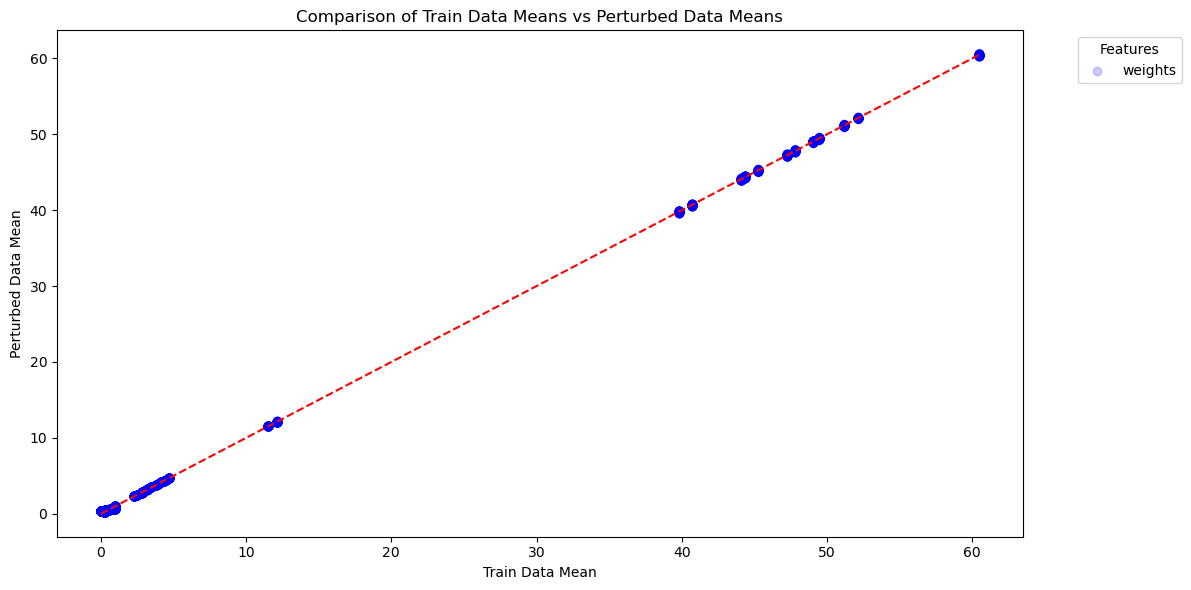

In [205]:
import matplotlib.pyplot as plt
import numpy as np

# Convert list of means for perturbed data to a DataFrame
perturbed_means_df = pd.DataFrame(perturbed_means)

# Step 3: Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot of perturbed means (y) vs train means (x)
for i, feature in enumerate(train_means.index):
    ax.scatter(np.repeat(train_means[feature], len(perturbed_means)), perturbed_means_df[feature].values, 
               color='blue', alpha=0.2, label=f'{feature}' if i == 0 else "")
    
# Add a line for perfect agreement (y = x)
plt.plot([min(train_means), max(train_means)],
         [min(train_means), max(train_means)], color='r', linestyle='--')

# Add labels and title
ax.set_xlabel('Train Data Mean')
ax.set_ylabel('Perturbed Data Mean')
ax.set_title('Comparison of Train Data Means vs Perturbed Data Means')

# Optionally, add a legend to describe features
ax.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [206]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

def compare_means_by_mode(perturbed_data, key_word):
    """
    Compare means of columns where 'interviewMode' is in the column name, 
    grouped by the interview mode categories (True/False).
    
    Parameters:
        perturbed_data (list of pd.DataFrame): List of DataFrames containing the perturbed data to analyze.
    
    Returns:
        p_vals (list of tuples): List of columns and their corresponding p-values from the t-tests.
    """
    p_vals = []
    
    # Iterate over each DataFrame in the list
    for i, df in enumerate(perturbed_data):
        print(f"\nAnalyzing DataFrame {i + 1}...\n")

        # Identify all columns that contain 'interviewMode' in their name
        interview_mode_columns = [col for col in df.columns if key_word in col]
        
        if not interview_mode_columns:
            print("No 'interviewMode' columns found.")
            continue
        
        #print(f"Found interview mode columns: {interview_mode_columns}")
        
        # Loop over all the numerical columns for comparison
        for col in df.select_dtypes(include=np.number).columns:
            #print(f"\nComparing column '{col}' based on interview modes.")

            # Compare the data for each interview mode column (True vs. False)
            for mode in interview_mode_columns:
                mode_true_data = df[df[mode] == True][col]  # Data where mode is True
                mode_false_data = df[df[mode] == False][col]  # Data where mode is False
                
                # Perform t-test between the two interview modes for this numerical column
                t_stat, p_value = ttest_ind(mode_true_data, mode_false_data, nan_policy='omit')
                
                # Append p-value for the column to the list
                p_vals.append((col, p_value))
                
                # Print results
                if p_value < 0.05:
                    print(f"The means for {mode} (True vs False) are significantly different in column '{col}'.")

    return p_vals


In [207]:
p_vals = compare_means_by_mode(perturbed_data, 'interviewMode')


Analyzing DataFrame 1...

The means for interviewMode_Web (True vs False) are significantly different in column 'weights'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_approvalOfPresidentCovidResponse'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoBiden'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoHarris'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoObama'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoDemParty'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_PartyID'.
The means for interviewMode_Web (True vs False) are significantly different in column 'Income'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_ThermoHarris'.
The means for intervie

The means for interviewMode_Web (True vs False) are significantly different in column 'HouseholdChildren'.

Analyzing DataFrame 18...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoBiden'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoObama'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoDemParty'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'Income'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'mentionFox'.

Analyzing DataFrame 19...

The means for interviewMode_Web (True vs False) are significantly different in column 'weights'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_CountryDirection'.
The means for interviewMode_Web (True vs False) are significantly different in column 

The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 34...

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_CountryDirection'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_GovTrust'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_EconomyView'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionFox'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 35...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_CountryDirection'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionFox'.

Analyzing DataFrame 36...

The means for interviewMode_Telephone (True vs False) are significantly diffe

The means for interviewMode_Web (True vs False) are significantly different in column 'weights'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoTrump'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoObama'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_YearsAtAddress'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'mentionFox'.

Analyzing DataFrame 51...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_SummaryVoteDutyChoice'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'HouseholdChildren'.
The means for interviewMode_Web (True vs False) are significantly different in col

The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoObama'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoDemParty'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoRepParty'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_PartyID'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ScaleGovAssistance'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_EconomyView'.
The means for interviewMode_Web (True vs False) are significantly different in column 'Income'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_VoteAccuracy'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ScaleMedInsurance'.
The me

The means for interviewMode_Telephone (True vs False) are significantly different in column 'mentionABC'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionCNN'.

Analyzing DataFrame 76...


Analyzing DataFrame 77...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_CountryDirection'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionFox'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 78...

The means for interviewMode_Web (True vs False) are significantly different in column 'weights'.
The means for interviewMode_Telephone (True vs False) are significantly different in c

The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 91...

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_approvalOfPresidentCovidResponse'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoDemParty'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_PartyID'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleMedInsurance'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleJobIncome'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_VoteAccuracy'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_ThermoBi

In [208]:
from collections import Counter

# Example of tracking how often each feature is significant
significant_features = [col for col, p_value in p_vals if p_value < 0.05]

feature_counts = Counter(significant_features)
sorted_feature_counts = feature_counts.most_common()

print(f"Features with the most significant differences: {sorted_feature_counts}")


Features with the most significant differences: [('mentionABC', 47), ('mentionFox', 35), ('PRE_CountryDirection', 23), ('PRE_ThermoBiden', 20), ('Income', 20), ('weights', 18), ('PRE_ThermoDemParty', 17), ('PRE_GovTrust', 17), ('HouseholdChildren', 17), ('PRE_PartyID', 15), ('PRE_SurveySeriousness', 15), ('PRE_ScaleMedInsurance', 15), ('POST_ThermoTrump', 14), ('PRE_religionImportance', 14), ('PRE_VoteAccuracy', 14), ('PRE_ThermoHarris', 13), ('PRE_ThermoObama', 13), ('PRE_ScaleDefenseSpending', 13), ('PRE_ThermoRepParty', 13), ('PRE_ScaleGovAssistance', 12), ('PRE_approvalOfPresidentCovidResponse', 11), ('POST_ThermoHarris', 11), ('POST_ThermoBiden', 11), ('PRE_EconomyView', 11), ('POST_VoteAccuracy', 10), ('PRE_YearsAtAddress', 10), ('PRE_ThermoTrump', 10), ('PRE_ThermoPence', 9), ('POST_ThermoPence', 9), ('PRE_ScaleJobIncome', 8), ('mentionCNN', 7), ('Age', 6), ('PRE_SummaryVoteDutyChoice', 3)]


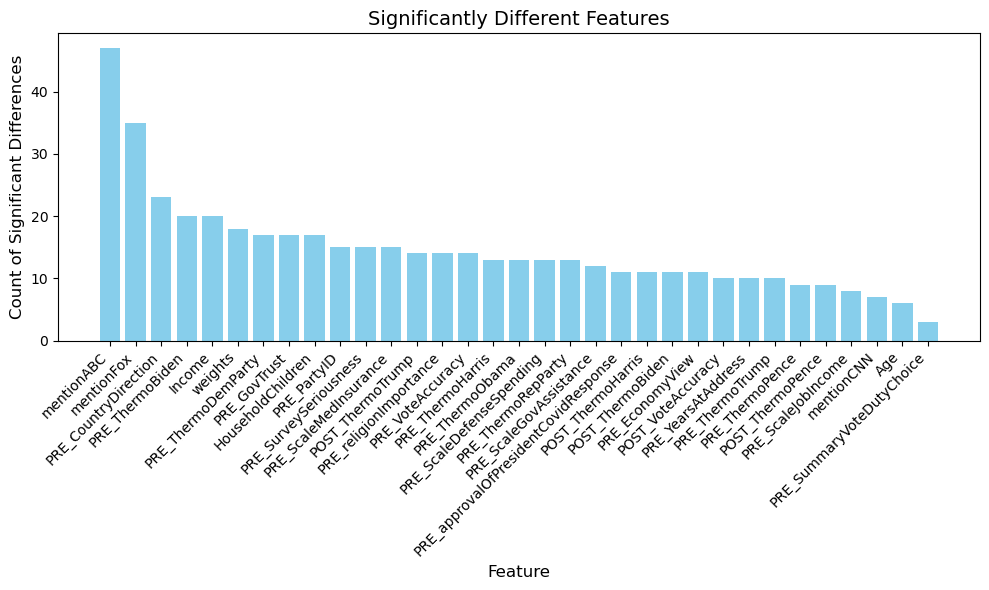

In [209]:
# Separate the feature names and their counts
features, counts = zip(*sorted_feature_counts)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(features, counts, color='skyblue')

# Adding titles and labels
plt.title('Significantly Different Features', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count of Significant Differences', fontsize=12)

# Rotate feature names if they are too long
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

In [6]:
import importlib
from functions import explore_data_helper
importlib.reload(explore_data_helper)

# create a list of 100 perturbed versions of ames_train_preprocessed using the perturb_ames function
perturbed_time_data = [explore_data_helper.perturb_dataframe(train_time_data) for i in range(100)]

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.08281222 0.98250464 2.2766419  ... 2.78366036 2.15194948 0.76962672]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.34450598 1.01220634 1.35220837 ... 2.09046749 0.73544141 2.72068585]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.15046241 0.8273837  1.08477844 ... 1.17235567 2.01202491 1.2871555 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.25226346 3.19117126 3.18179856 ... 2.26161684 1.91464008 2.23308282]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.93291726 2.90236439 1.27548001 ... 1.73409995 1.15246573 0.82474367]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.09484972 2.19422273 0.9998934  ... 1.93743992 3.26580659 2.89077318]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.84982513 1.80767223 1.06209527 ... 2.16922425 1.04671202 2.09291181]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.31548904 1.63224612 3.34459593 ... 2.1101945  2.75225897 1.93211106]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.06218374 2.20332407 1.93636316 ... 0.94702025 1.12105214 1.08824639]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.16134043 2.80462184 2.02942717 ... 1.91550561 2.06171463 2.66168633]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.22288286 1.14914179 1.21810723 ... 0.86275331 2.13288058 0.91003085]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.24990479 2.87290609 0.2162193  ... 0.79660923 0.95341658 2.97685318]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.06224471 1.14270979 1.21071845 ... 1.25215477 1.93082583 0.97711261]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.31548599 3.08037041 3.18980478 ... 1.63086285 1.67291601 1.93862514]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.2661474  0.93972287 2.19213553 ... 1.10845517 1.04977773 0.84683703]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.82121616  1.66323369 -0.13056866 ...  2.15171265  1.63245569
  1.96785035]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.95041161 2.11961205 2.28387119 ... 2.14952563 0.97986534 1.13596835]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.16525567 0.97130892 1.22898444 ... 1.72001755 0.86873638 2.36952896]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.85195747 1.1942861  1.12383425 ... 1.20283329 0.77348878 1.759325  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.89405552 1.96891967 1.64632497 ... 3.22061265 1.65079306 1.1807733 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.77480309 1.1101936  1.13761875 ... 2.05065763 1.19649833 1.06256724]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.39598328 2.06522283 1.86831894 ... 0.64920642 2.22679939 1.76371065]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.83815844 1.77527709 0.85303568 ... 0.95336514 0.99509633 2.87502475]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.34417642 1.69632707 1.08405898 ... 0.83823887 2.73314299 2.84827911]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.07209911 1.74980212 1.08599545 ... 1.12606704 0.8811836  1.19041006]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.74808523 1.03275365 1.95019166 ... 2.98020152 1.77841122 2.15304378]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.9843399  1.10716205 0.77296866 ... 1.75108674 0.95467985 1.71322335]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.96612812 3.30422317 1.70932563 ... 0.92928895 2.23568226 2.33675819]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.14461804 2.09442337 1.05482206 ... 0.99106561 1.09576489 0.78056397]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.35760785 1.77424109 1.65288068 ... 1.81699337 2.03459173 3.16539215]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.08777603 0.99855828 1.2838832  ... 2.03644754 1.00997112 1.83760891]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.01426844 2.23874727 3.00129902 ... 2.89218883 3.29540993 2.9594247 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.05554315 1.10271462 1.2841677  ... 0.99362961 1.17557156 1.72647989]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.7116534   3.18135407  2.66818761 ...  2.28630037  2.38927472
 -0.05101131]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0483192  1.24850594 1.98713126 ... 2.09552383 2.0143499  1.26221264]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.37083685 3.15834694 3.15917718 ... 2.33446576 0.9336457  2.30773777]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.25310045 2.15856014 1.88211781 ... 2.18857633 2.03894034 1.83528508]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.93198846 1.00124646 2.07342149 ... 1.74642946 2.38728476 2.22190503]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.96747464 1.18435806 1.0576571  ... 1.07078945 0.99210133 1.8671151 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.1502986  1.70425747 0.77200855 ... 1.74522216 2.14967505 3.00930458]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.75163544 1.06962226 0.83167805 ... 0.80478998 2.14003065 1.03758643]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.98940468 3.26407824 2.86620089 ... 3.25189459 2.9838622  3.0601895 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.73276337 1.94693271 0.97722202 ... 1.23757896 0.72842141 1.96983148]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.8372459  2.85355745 1.64675067 ... 1.9986133  0.93727487 1.86930875]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.28669049 2.16567442 2.17740772 ... 0.97061383 1.27062766 1.13956885]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.91783884 3.3645237  2.95296313 ... 2.11788755 1.10139238 2.75663711]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.95995058 0.78831445 2.14052249 ... 0.71281141 2.15523442 1.04904279]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.39139699 0.70374259 2.71110837 ... 2.01859609 3.05530266 3.36516546]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.72581317 2.04449519 0.88399731 ... 0.77756439 1.18200749 1.12953411]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.72220392 2.90117535 1.86794935 ... 3.3564636  0.9829323  2.19306851]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.71329707 2.083749   1.0243475  ... 1.12580441 0.91383918 1.03701382]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.99657601 0.64978775 2.31439395 ... 1.34951566 3.12403449 2.09093048]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.04072993 0.95743598 1.03818363 ... 1.942023   1.09005781 1.25218955]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.30936305 2.83236313 1.09328099 ... 0.90861053 2.30545406 3.02338386]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.94515937 1.22473634 2.22780593 ... 0.89590407 0.91628548 1.29014025]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.30751062 2.75017613 2.01062328 ... 2.21135946 1.84553058 0.91394172]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.05091874 1.00872514 1.11218702 ... 1.19259984 0.7161192  1.94951011]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.83730696 2.28122474 1.32648651 ... 2.60584693 3.09089009 2.09160377]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.85707514 1.78333154 0.85475573 ... 1.23153049 0.7257731  1.84245029]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.83608492  0.96060696 -0.36706602 ...  3.21338953  3.27889545
  1.80776014]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.13251915 1.09810625 1.09251507 ... 0.75857494 2.01672526 2.06442097]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.20499352 2.71836725 2.97105838 ... 0.85113543 1.91029991 2.08000366]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.11587229 0.84542012 1.71392979 ... 1.79818958 1.07631568 3.20857891]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.91453517 1.76113524 1.62856913 ... 1.85269959 0.38468698 2.97386748]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.28824534 1.24860059 0.89282304 ... 1.18549264 1.26616672 0.98062098]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.78601038 2.83764789 2.24670231 ... 3.05393946 3.30885066 1.6246072 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.24094389 1.99589807 2.08578502 ... 1.01692453 1.14385273 0.9395999 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.61118367 1.34957621 1.90323902 ... 2.75448642 2.95885168 0.88136247]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.77217326 2.02436309 2.09629833 ... 2.24411036 1.1953631  0.98403971]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.36213463 1.94681501 2.36890355 ... 1.05051255 1.655931   1.08152078]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.17819013 0.7292981  0.89387117 ... 1.15838741 2.06962625 0.97012749]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.8207628  2.71917148 1.8029372  ... 2.75888305 1.18458094 2.38811798]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.7345472  1.07040077 1.15981154 ... 0.75082089 0.81693098 2.27535981]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.26789237  2.3039631  -0.07731598 ...  1.16071361  3.37456517
  3.34968693]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.72547598 1.1863735  0.91787636 ... 0.74933073 0.92636036 0.90441071]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.76102224 1.93723463 1.74153519 ... 2.1294814  2.64444589 1.86129311]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.28677417 1.26226334 1.17076501 ... 1.02861961 1.18261747 1.83178289]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.63293188 3.21180986 1.89833475 ... 2.04752688 3.37394992 3.05025599]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.89013319 0.81194046 0.95283846 ... 1.22425466 0.90514868 2.15705808]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.6613579  1.15241073 3.00162863 ... 2.79428816 1.83398374 0.67347427]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.13626579 0.78599707 3.04647032 ... 0.95126779 2.08082833 0.84737464]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.1001273  1.61045008 0.74459445 ... 1.08335027 2.31535416 2.67645811]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.10211096 2.19664551 1.21439196 ... 1.9120759  1.09843482 0.874477  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.83646367 1.89222101 2.25698866 ... 2.88478418 1.84906623 3.09023025]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.07484959 1.01808942 1.08606361 ... 1.061953   0.73304378 2.10180839]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.06005417  2.23461086  2.61849119 ...  1.68704468  0.61029669
 -0.0492172 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.01751232 2.09484086 2.057152   ... 2.02315598 2.86861772 2.11938464]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.0983265  2.60729911 2.31144231 ... 3.06357352 2.03905659 2.78389482]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.16619235 1.08538247 0.8764445  ... 0.7581535  2.01033059 2.28339912]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.33295459 0.84593372 1.86145594 ... 1.82058045 2.02560317 1.93665832]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.06841115 0.77349592 0.91128171 ... 1.7764659  1.92033    0.86555704]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.89917095 3.24092158 2.84778363 ... 1.21175006 1.86810197 1.60238207]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.770261   1.0214539  3.21711627 ... 3.16275661 2.072691   2.08387692]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.67639107  2.02925059 -0.17702373 ...  2.18636085  2.90353584
  3.14167959]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.90881802 1.86334079 0.79479078 ... 0.7528591  2.0280481  0.73316437]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.16085843 1.83059913 2.92725152 ... 2.36153006 1.68332901 2.83525543]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.48557225 1.88567884 2.82950126 ... 2.28514302 1.3221118  0.54789306]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.07544424 1.22309301 2.11172937 ... 1.9251414  2.12418119 1.91590546]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.05927189 0.98789417 1.16796822 ... 2.15003171 1.23343487 0.89571074]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.32277253 0.73958307 1.73554505 ... 2.29621163 0.9101946  0.7108116 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Docu

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Assuming train_data and perturbed_data are DataFrames
# Assuming explore_data_helper.perturb_dataframe is defined

# Step 1: Calculate the mean for each column in train_data
train_time_means = train_time_data.mean()

# Step 2: Calculate the means for each perturbed dataset and store the results
perturbed_time_means = []

for perturbed_df in perturbed_time_data:
    perturbed_time_means.append(perturbed_df.mean())

# Step 3: Perform T-tests to compare means for each column between train_data and perturbed datasets
p_values = {}

# Iterate over each column in the train_data (and perturbed data)
for column in train_time_data.columns:
    # Get the mean of the train_data for this column
    train_column_values = train_time_data[column]
    
    # Store the p-values for each perturbation (compare with the train data)
    p_vals_for_column = []
    
    for perturbed_mean in perturbed_time_means:
        perturbed_column_values = perturbed_mean[column]
        
        # Perform a two-sample t-test between the train data and perturbed data
        t_stat, p_val = ttest_ind(train_column_values, perturbed_column_values)
        p_vals_for_column.append(p_val)
    
    # Store the average p-value for this column across all perturbations
    p_values[column] = np.mean(p_vals_for_column)

# Step 4: Analyze p-values to check for statistically significant differences
# Typically, a p-value below 0.05 suggests a significant difference
significant_columns = {col: p_val for col, p_val in p_values.items() if p_val < 0.05}

# Print columns with significant differences
print("Columns with significant differences in Time Series (p-value < 0.05):")
for col in significant_columns:
    print(f"{col}: p-value = {significant_columns[col]}")


Columns with significant differences in Time Series (p-value < 0.05):
Race_Asian_Pacific Islander: p-value = 0.02446002630220034
Race_American Indian_Alaska Native: p-value = 0.0029945242100194924
Race_Other: p-value = 0.019175192622685282
